In [ ]:
import pandas as pd
import numpy as np

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Layer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import models

import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import statistics as st

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#dir = '/content/gdrive/My Drive/Colab Notebooks/cs4248/Project/'
dir = "data/"

In [ ]:
def load_data(train_file, test_file, column_name):
    train_df = pd.read_csv(train_file, names=column_name)
    test_df = pd.read_csv(test_file, names=column_name)
    return train_df, test_df

In [ ]:
def preprocess_data(train_df, test_df):
    import time
    start = time.time()
    minute = 0

    for df in [train_df, test_df]:
        for i in range(df.shape[0]):
            if time.time() - start >= minute * 60:
                print(str(minute) + " minutes: " + str(i) + " iterations done.")
                minute += 1
            df.at[i, "text"] = tokenize(df.at[i, "text"])

    return train_df, test_df

In [ ]:
# For RNN
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti_analyzier = SentimentIntensityAnalyzer()
def get_senti(sentence):
    score = senti_analyzier.polarity_scores(sentence)['compound']

    if score > 0.05:
        return 1
    if score < -0.05:
        return -1
    return 0

In [ ]:
def get_train_test_data(x_train, y_train, x_test, y_test, mode, maxlen, n_unique_words):
    # tokenize the data
    tokenizer = Tokenizer(num_words=n_unique_words)
    tokenizer.fit_on_texts(x_train)
    sequences = tokenizer.texts_to_sequences(x_train)
    x_train = pad_sequences(sequences, maxlen=maxlen)
    y_train = to_categorical(y_train - 1, num_classes=4)

    if mode == 'valid':
        return train_test_split(x_train, y_train, test_size=0.2, random_state=42), tokenizer

    sequences = tokenizer.texts_to_sequences(x_test)
    x_test = pad_sequences(sequences, maxlen=maxlen)
    y_test = to_categorical(y_test - 1, num_classes=4)
    return x_train, x_test, y_train, y_test, tokenizer

In [ ]:
# Config
mode = 'test'
maxlen = 200
n_unique_words = 20000

In [ ]:
train_path = dir + "fulltrain.csv"
test_path = dir + "balancedtest.csv"

xlnet_path = "xlnet"
rnn_path = "rnn"
lstm_path = "lstm"

In [ ]:
train_df, test_df = load_data(train_path, test_path, ["label", "text"])

In [ ]:
train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [ ]:
test_df.head()

,label,text
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...


In [ ]:
x_train, y_train = train_df["text"].values, train_df["label"].values
x_test, y_test = test_df["text"].values, test_df["label"].values

In [ ]:
x_test[3]

'North Koreas official news agency announced today that the militarys planned missile test had been put on hold because of problems with Windows 8. Intelligence analysts said that the announcement gave rare insight into the inner workings of North Koreas missile program, which until last year had been running on Windows 95. The announcement from the Korean Central News Agency (KCNA) did not indicate a new scheduled time for a missile test, saying only that it was working with Windows 8 support to resolve the issue. In the words of one intelligence analyst, That means the test has been delayed indefinitely. A source close to the North Korean regime reported that Supreme Leader Kim Jong-un is furious about the Windows 8 problems and is considering a number of options, including declaring war on Microsoft. '

In [ ]:
X_train, X_test, y_train, y_test, tokenizer = get_train_test_data(x_train, y_train, x_test, y_test, mode, maxlen, n_unique_words)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
rnn = models.load_model(rnn_path)

2023-04-02 08:00:54.467907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
lstm = models.load_model(lstm_path)

In [ ]:
import shap

In [ ]:
explainer = shap.KernelExplainer(lstm.predict, shap.kmeans(X_train, 100))

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


4/4 [==============================] - 0s 26ms/step


In [ ]:
shap_values = explainer.shap_values(X_test[200:201])
# shap_values = explainer.shap_values(X_test, n_samples=100)

  0%|          | 0/1 [00:00<?, ?it/s]

7650/7650 [==============================] - 224s 29ms/step


In [ ]:
shap.initjs()

num2word = tokenizer.index_word

x_test_words = np.stack([np.array([num2word.get(X_test[i][j], "NONE") + "({})".format(j) for j in range(len(X_test[i]))]) for i in range(200, 201)])

index = 0
label = 0

shap.force_plot(explainer.expected_value[label], shap_values[label][index], x_test_words[index])

In [ ]:
#shap.force_plot(explainer.expected_value[label], shap_values[label], x_test_words)

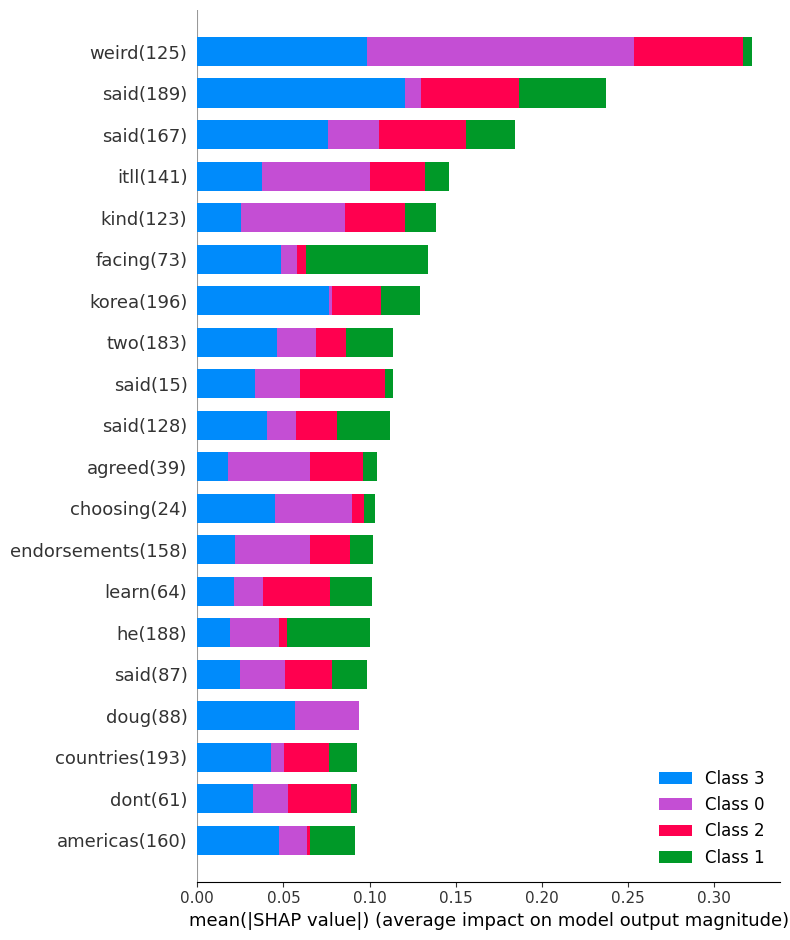

In [ ]:
shap.summary_plot(shap_values, features=x_test_words[0])

In [ ]:
def rnn_predict(inputs):
    inputs = np.array(tokenizer.sequences_to_texts(inputs))
    
    sentiments = np.array([get_senti(text) for text in inputs])
    rnn_pred = rnn.predict([inputs, sentiments])
    return rnn_pred

In [ ]:
rnn_explainer = shap.KernelExplainer(rnn_predict, shap.kmeans(X_train, 100))

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


4/4 [==============================] - 0s 7ms/step


In [ ]:
rnn_shap_values = rnn_explainer.shap_values(X_test[200:201])

  0%|          | 0/1 [00:00<?, ?it/s]

7650/7650 [==============================] - 73s 10ms/step


In [ ]:
shap.initjs()

num2word = tokenizer.index_word

rnn_test_words = np.stack([np.array([num2word.get(X_test[i][j], "NONE") + "({})".format(j) for j in range(len(X_test[i]))]) for i in range(200, 201)])

index = 0
label = 0

shap.force_plot(rnn_explainer.expected_value[label], rnn_shap_values[label][index], rnn_test_words[index])

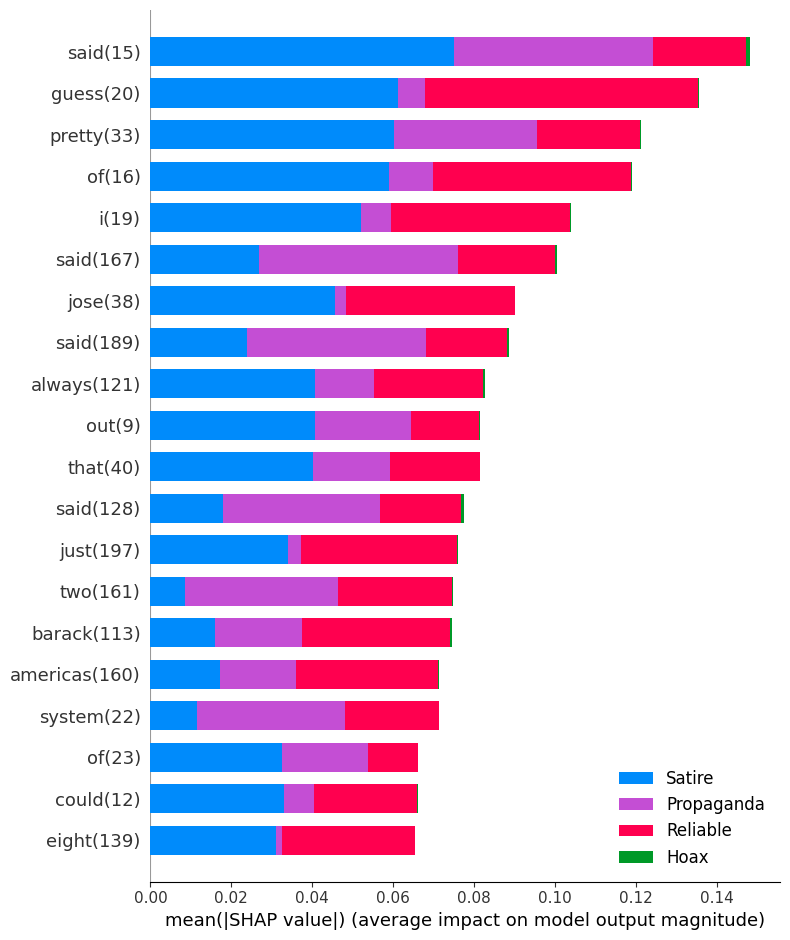

In [ ]:
shap.summary_plot(rnn_shap_values, features=rnn_test_words[0], class_names=["Satire", "Hoax", "Propaganda", "Reliable"])